# Blood Sample Data

#### Importing Libraries

In [194]:
import time
start_time = int(time.time())
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential, Model
from keras.layers import *
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

#### Reading the Data

In [14]:
pos=pd.read_csv('/Users/deba_mycol/Zevac_Unified/zevac_unified/pp.csv', usecols=['slno', 'hosp_admission_id', 'hosp_patient_id', 
       'age','sex', 'department', 'sample_type', 'ward_name', 'caretype',
       'num_prev_adm', 'sc_date', 'interval', 'catheter', 'cancer',
       'cerebrovascular_disease', 'dementia_or_alzheimers', 'diabetes',
       'heart_disease', 'hiv_or_aids', 'hypertension', 'liver_disease',
       'pulmonary_disease_asthma', 'renal_disease',
       'rheumatic_or_connective_tissue_disease', 'no_comorbidity',
       'bacteria_name', 'antibiotic_name', 'gram', 'susceptibility'])

#### Getting Blood Sample Data

In [15]:
blood=pos[pos['sample_type']=='Blood']
blood=blood[blood['sex']!='Others'].reset_index(drop=True)

In [16]:
df=blood[['age', 'sex', 'caretype', 'department', 'num_prev_adm', 'interval', 'catheter', 
      'cancer', 'cerebrovascular_disease', 'dementia_or_alzheimers', 'diabetes',
      'heart_disease', 'hiv_or_aids', 'hypertension', 'liver_disease',
      'pulmonary_disease_asthma', 'renal_disease', 'rheumatic_or_connective_tissue_disease', 'no_comorbidity', 
      'bacteria_name', 'antibiotic_name', 'susceptibility']]
df=df.drop_duplicates()
df=df.reset_index(drop=True)

#### Creating Training Data

In [18]:
train, test = train_test_split(df, test_size=0.3, random_state=0)

In [19]:
train.susceptibility.value_counts()

R    10784
S     9985
Name: susceptibility, dtype: int64

#### Shuffling Training Data

In [20]:
train = train.sample(frac=1).reset_index(drop=True)

#### Taking Out Target Column and Dropping Unnecesary Columns

In [22]:
train_labels = train['susceptibility']

In [47]:
df_train = train.drop("bacteria_name", 1)
df_train = df_train.drop("susceptibility", 1)
all_cols = df_train.columns
for col in all_cols:
    if df_train[col].nunique()<2:
        df_train = df_train.drop(col, 1)
all_cols = df_train.columns

In [48]:
len(all_cols)

17

#### Breaking Into 3 Types of Columns: Binary, Categorical and Other (Ordinal or Continous)

In [49]:
categorical_vars = [ ]
continuous_vars = [ ]
categorical_binary_vars = [ ]

for col in all_cols:
    if df_train[col].nunique()==2:
        categorical_binary_vars.append(col)
    else:
        if df_train[col].dtypes=='object':
            categorical_vars.append(col)
        else:
            continuous_vars.append(col)

In [50]:
print ("categorical binary vars: ", len(categorical_binary_vars))
print ("categorical non binary vars: ", len(categorical_vars))
print ("continuous vars: ", len(continuous_vars))

categorical binary vars:  13
categorical non binary vars:  2
continuous vars:  2


In [52]:
all_categorical_vars = categorical_binary_vars + categorical_vars
print ("all categorical vars: ", len(all_categorical_vars))

all categorical vars:  15


#### Displaying Number of Unique Values in Each Categorical Variable Column

In [55]:
for cat_var in all_categorical_vars:
    print (cat_var,":", df_train[cat_var].nunique())

sex : 2
caretype : 2
catheter : 2
cancer : 2
cerebrovascular_disease : 2
diabetes : 2
heart_disease : 2
hypertension : 2
liver_disease : 2
pulmonary_disease_asthma : 2
renal_disease : 2
rheumatic_or_connective_tissue_disease : 2
no_comorbidity : 2
department : 40
antibiotic_name : 40


#### Creating Training and Validation Data

In [57]:
df_tr = df_train[:15000]
df_val = df_train[15000:]

In [56]:
Y_train  = train_labels[:15000]
Y_val  = train_labels[15000: ]

# Categorical Embedding

#### Printing Two Different Types of Variables Namely Categorical and Continuous/Ordinal

In [58]:
print(all_categorical_vars)
print(continuous_vars)

['sex', 'caretype', 'catheter', 'cancer', 'cerebrovascular_disease', 'diabetes', 'heart_disease', 'hypertension', 'liver_disease', 'pulmonary_disease_asthma', 'renal_disease', 'rheumatic_or_connective_tissue_disease', 'no_comorbidity', 'department', 'antibiotic_name']
['age', 'interval']


#### Preprocessing Training and Validation Data

In [59]:
def preprocessing(X_train):
    input_list_train = []
    #the cols to be embedded: rescaling to range [0, # values)
    for c in all_categorical_vars:
        vals = np.asarray(X_train[c].tolist())
        vals = pd.factorize(vals)[0]
        input_list_train.append(np.asarray(vals))
        """
        This below is another method to do this:
        val_map = {}
        for i in range(len(raw_vals)):
            val_map[raw_vals[i]] = i       
        input_list_train.append(X_train[c].map(val_map).values)
        """
    #the rest of the columns
    input_list_train.append(X_train[continuous_vars].values)
    return input_list_train

In [61]:
df_tr_modified = preprocessing(df_tr)
df_val_modified = preprocessing(df_val)

#### As Expected, The Proceesed Training DataFrame has 16 Elements Becasue We had 15 Categorical Columns and One for Other (Continous/Ordinal) Columns

In [66]:
len(df_tr_modified)

16

#### The Embedding Size is Set According to the Rule As Suggested by fast.ai Course and Entity Embedding Paper

Embedding_size  = integer value of min(ceiling(no of unique categories/2) , 50)

#### Each Model will be Appended to a List Named Models

In [113]:
%%html
<p style="color:red">Since Merge is Deprecated in Keras 2.2.2 We Shift to Functional API Rather Than Using Sequential Model</p>


In [226]:
models=[]
inputs=[]
embeddings=[]
functional_models=[]

In [222]:
%%html
<p style="color:red">Function to Convert Sequential Model to Functional API Model</p>


In [227]:
def get_functional(model):
    input_layer = Input(batch_shape=model.layers[0].input_shape)
    prev_layer = input_layer
    for layer in model.layers:
        prev_layer = layer(prev_layer)
    functional_model = keras.models.Model([input_layer], [prev_layer])
    return input_layer, prev_layer, functional_model

#### Following Code Adds an Embedding Network for Each of the Catgeoriacal Variables   

In [228]:
for variable in all_categorical_vars:
    print("For categorical column: ", variable)
    print("----------------------------------------------------------------------")
    model = Sequential()
    no_of_unique_categories  = df_train[variable].nunique()
    print("Number of unique categories: ",no_of_unique_categories)
    embedding_size = min(np.ceil(no_of_unique_categories/2), 50)
    embedding_size = int(embedding_size)
    print("Embedding size set as: ", embedding_size)
    model.add(Embedding(no_of_unique_categories+1, embedding_size, name=variable+'_embedding', input_length = 1))
    model.add(Reshape(target_shape=([embedding_size])))
    print(model.summary())
    input_layer, embedding, functional_model = get_functional(model)
    models.append(model)
    functional_models.append(functional_model)
    inputs.append(input_layer)
    embeddings.append(embedding)

For categorical column:  sex
----------------------------------------------------------------------
Number of unique categories:  2
Embedding size set as:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sex_embedding (Embedding)    (None, 1, 1)              3         
_________________________________________________________________
reshape_139 (Reshape)        (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
For categorical column:  caretype
----------------------------------------------------------------------
Number of unique categories:  2
Embedding size set as:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
caretype_embedding (Embeddin (None, 1, 1)              3         
____________________

For categorical column:  rheumatic_or_connective_tissue_disease
----------------------------------------------------------------------
Number of unique categories:  2
Embedding size set as:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rheumatic_or_connective_tiss (None, 1, 1)              3         
_________________________________________________________________
reshape_150 (Reshape)        (None, 1)                 0         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________
None
For categorical column:  no_comorbidity
----------------------------------------------------------------------
Number of unique categories:  2
Embedding size set as:  1
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
no_comorbidity_embedding (Em (None, 1, 1)    

#### Once the Embedding for Categorical Columns are Made, We Add Another Single Model for All the Continuous Variables and Add it to the Models List


In [230]:
model_rest = Sequential()
model_rest.add(Dense(16, input_shape = [2]))
model_rest.summary() 
input_layer_rest, embedding_rest, functional_model_rest = get_functional(model_rest)
models.append(model_rest)
functional_models.append(functional_model_rest)
inputs.append(input_layer_rest)
embeddings.append(embedding_rest)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 16)                48        
Total params: 48
Trainable params: 48
Non-trainable params: 0
_________________________________________________________________


#### Our Models List will Contain (Number of categorical variables)+1 Models, where Number of categorical variables = 15

In [231]:
models

In [232]:
functional_models

#### Finally We Merge All the Models Present into a Single Model Using Concat Method which Places the Models One After the Other


In [233]:
input_layer_full = Concatenate()(embeddings)

#### With Input Layers and Embedding Layers Done We can Build on Those as Any Other keras Functional Model.

Adding a few layers below

In [234]:
input_layer_full = Dense(128, activation='relu')(input_layer_full)
input_layer_full = Dropout(.5)(input_layer_full)
input_layer_full = Dense(64, activation='relu')(input_layer_full)
input_layer_full = Dropout(.25)(input_layer_full)
input_layer_full = Dense(32, activation='relu')(input_layer_full)
input_layer_full = Dropout(.15)(input_layer_full)
output = Dense(1, activation='sigmoid')(input_layer_full)

#### Creating the Full Model with All Variables

In [235]:
full_model = Model(inputs, output)

In [236]:
full_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [237]:
full_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_130 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_131 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_132 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_133 (InputLayer)          (None, 1)            0                                            
__________________________________________________________________________________________________
input_134 

#### Model Training and Validation

In [238]:
from keras.utils.np_utils import to_categorical
Y_train = Y_train.apply(lambda x: 1 if x=='S' else 0)
Y_val = Y_val.apply(lambda x: 1 if x=='S' else 0)
Y_train_cat = to_categorical(Y_train.tolist())
Y_val_cat = to_categorical(Y_val.tolist())

In [239]:
full_model.fit(df_tr_modified, Y_train_cat)

Epoch 1/1
15000/15000 [==============================] - 4s 293us/step - loss: 0.0254 - acc: 0.9959


In [240]:
full_model.evaluate(df_val_modified, Y_val_cat)

5769/5769 [==============================] - 1s 137us/step


[5.8946640264502e-05, 1.0]

#### Plot Categorical Embeddings with Categories>2

In [303]:
from sklearn import manifold
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

In [350]:
antibiotic_categories = df_train['antibiotic_name'].unique().tolist()
antibiotic_embedding = full_model.get_layer('antibiotic_name_embedding').get_weights()[0]
antibiotic_embedding

array([[-0.04048283, -0.00585906, -0.01924037, -0.02927114, -0.0007631 ,
        -0.08061161, -0.04700429, -0.01143189, -0.00318541, -0.0282432 ,
        -0.00255386, -0.03514312,  0.02965967,  0.00883416, -0.050426  ,
        -0.05580542, -0.07512423,  0.01722782,  0.01898246,  0.04482304],
       [-0.07789271, -0.02385456, -0.00358035, -0.0337573 ,  0.01721867,
        -0.05986843, -0.05631705,  0.01020078, -0.05649761, -0.01142982,
        -0.00173015, -0.02457146,  0.02712609,  0.02918476,  0.01298726,
        -0.03625513, -0.03350233,  0.04078627,  0.04577587, -0.03227778],
       [-0.02925926, -0.04428622, -0.05683782,  0.03234605, -0.02001789,
        -0.0419681 , -0.01280108,  0.00221938,  0.01196571, -0.05047962,
        -0.03417087, -0.03998949, -0.01703581,  0.02158504,  0.00534361,
         0.00934158,  0.0248097 ,  0.06722508, -0.0116152 ,  0.01631728],
       [-0.02139294,  0.00043079, -0.05739878,  0.02678366,  0.02749228,
        -0.02980699, -0.03579749,  0.01404464,  

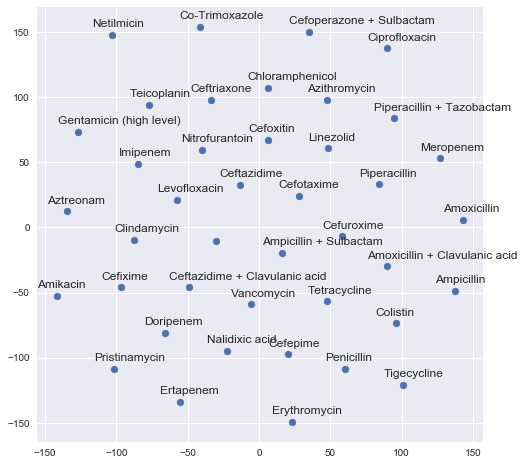

In [351]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(antibiotic_embedding)
plt.figure(figsize=(8,8))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(antibiotic_categories):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

In [352]:
department_categories = df_train['department'].unique().tolist()
department_embedding = full_model.get_layer('department_embedding').get_weights()[0]
department_embedding

array([[ 0.01482588,  0.03811129,  0.02428532, -0.04605605, -0.02022308,
        -0.0254326 ,  0.03998599,  0.02780085, -0.00475109,  0.04583199,
         0.0239218 ,  0.03966118,  0.02920127, -0.03828612,  0.03569863,
        -0.01452632,  0.01181022,  0.00955364,  0.03297164,  0.0139455 ],
       [-0.01539137, -0.01384889,  0.00853118,  0.01834874,  0.01347844,
        -0.02558445,  0.0354282 , -0.01115156, -0.01897947, -0.01335581,
        -0.03035626, -0.04732979, -0.01148001, -0.05794528, -0.05487733,
         0.04315067, -0.00942493,  0.02150484,  0.0237734 , -0.00659832],
       [ 0.07015148,  0.04305584,  0.00452981, -0.03718448,  0.02769082,
         0.01818794,  0.03113101, -0.00778884, -0.03251214, -0.03787501,
         0.04126846,  0.00795876, -0.06386009, -0.0204648 , -0.03033328,
         0.03649001, -0.02880806,  0.00179651,  0.00724588,  0.00208176],
       [-0.01965958,  0.01357682, -0.00785981,  0.04119084,  0.01251465,
         0.02819652,  0.0259967 ,  0.03806066, -

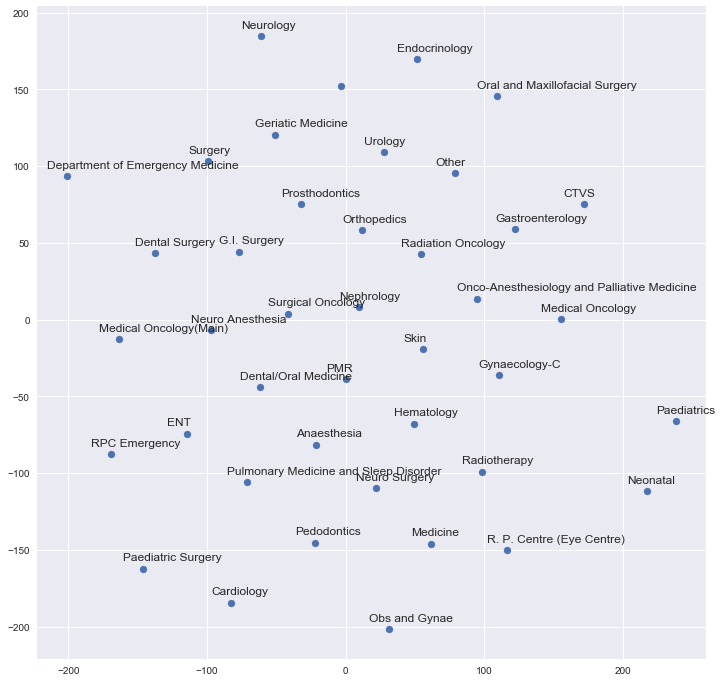

In [353]:
tsne = manifold.TSNE(init='pca', random_state=0, method='exact')
Y = tsne.fit_transform(department_embedding)
plt.figure(figsize=(12,12))
plt.scatter(-Y[:, 0], -Y[:, 1])
for i, txt in enumerate(department_categories):
    plt.annotate(txt, (-Y[i, 0],-Y[i, 1]), xytext = (-20, 8), textcoords = 'offset points')

#### Plotting Pairwise Distances for Antibiotics (Embedding Vectors)

In [354]:
from scipy.spatial import distance
distances = pd.DataFrame(columns=['Antibiotic1', 'Antibiotic2', 'Distance'])
ab1=[]
ab2=[]
dist=[]
for i in range(len(antibiotic_categories)):
    for j in range(len(antibiotic_categories)):
        if j!=i:
            ab1.append(antibiotic_categories[i])
            ab2.append(antibiotic_categories[j])
            dist.append(distance.euclidean(antibiotic_embedding[i].reshape(-1, 1), antibiotic_embedding[j].reshape(-1, 1)))

distances['Antibiotic1'] = pd.Series(ab1)
distances['Antibiotic2'] = pd.Series(ab2)
distances['Distance'] = pd.Series(dist)
distances = distances.sort_values(by=['Distance']).reset_index(drop=True)
distances

Antibiotic1                    Antibiotic2  Distance
0                       Clindamycin                       Cefixime  0.119085
1                          Cefixime                    Clindamycin  0.119085
2                         Linezolid                      Cefoxitin  0.121787
3                         Cefoxitin                      Linezolid  0.121787
4                         Doripenem  Ceftazidime + Clavulanic acid  0.122577
5     Ceftazidime + Clavulanic acid                      Doripenem  0.122577
6                         Cefoxitin                       Amikacin  0.124386
7                          Amikacin                      Cefoxitin  0.124386
8                       Ceftazidime                 Nitrofurantoin  0.128142
9                    Nitrofurantoin                    Ceftazidime  0.128142
10                    Ciprofloxacin                      Linezolid  0.128217
11                        Linezolid                  Ciprofloxacin  0.128217
12                       Vancomycin                 Nalidixic acid  0.130989
13                   Nalidixic acid                     Vancomycin  0.130989
14                     Tetracycline                      Doripenem  0.131753
15                        Doripenem                   Tetracycline  0.131753
16                   Nitrofurantoin                    Ceftriaxone  0.133471
17                      Ceftriaxone                 Nitrofurantoin  0.133471
18                    Pristinamycin                      Doripenem  0.134101
19                        Doripenem                  Pristinamycin  0.134101
20                   Nitrofurantoin                    Clindamycin  0.134735
21                      Clindamycin                 Nitrofurantoin  0.134735
22                        Cefoxitin                   Azithromycin  0.136384
23                     Azithromycin                      Cefoxitin  0.136384
24                     Levofloxacin                       Imipenem  0.137631
25                         Imipenem                   Levofloxacin  0.137631
26                        Linezolid       Cefoperazone + Sulbactam  0.139062
27         Cefoperazone + Sulbactam                      Linezolid  0.139062
28                        Linezolid                    Teicoplanin  0.139290
29                      Teicoplanin                      Linezolid  0.139290
...                             ...                            ...       ...
1530        Gentamicin (high level)                   Erythromycin  0.248774
1531                   Erythromycin        Gentamicin (high level)  0.248774
1532                  Pristinamycin                    Teicoplanin  0.249035
1533                    Teicoplanin                  Pristinamycin  0.249035
1534       Cefoperazone + Sulbactam                       Cefepime  0.250104
1535                       Cefepime       Cefoperazone + Sulbactam  0.250104
1536                 Nalidixic acid                      Meropenem  0.250555
1537                      Meropenem                 Nalidixic acid  0.250555
1538      Piperacillin + Tazobactam        Gentamicin (high level)  0.254340
1539        Gentamicin (high level)      Piperacillin + Tazobactam  0.254340
1540                 Co-Trimoxazole                 Nalidixic acid  0.254394
1541                 Nalidixic acid                 Co-Trimoxazole  0.254394
1542        Gentamicin (high level)                       Cefepime  0.255098
1543                       Cefepime        Gentamicin (high level)  0.255098
1544                       Cefixime                      Meropenem  0.256260
1545                      Meropenem                       Cefixime  0.256260
1546       Cefoperazone + Sulbactam                    Amoxicillin  0.258793
1547                    Amoxicillin       Cefoperazone + Sulbactam  0.258793
1548        Gentamicin (high level)                    Tigecycline  0.261416
1549                    Tigecycline        Gentamicin (high level)  0.261416
1550                

/anaconda2/envs/py36/lib/python3.6/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


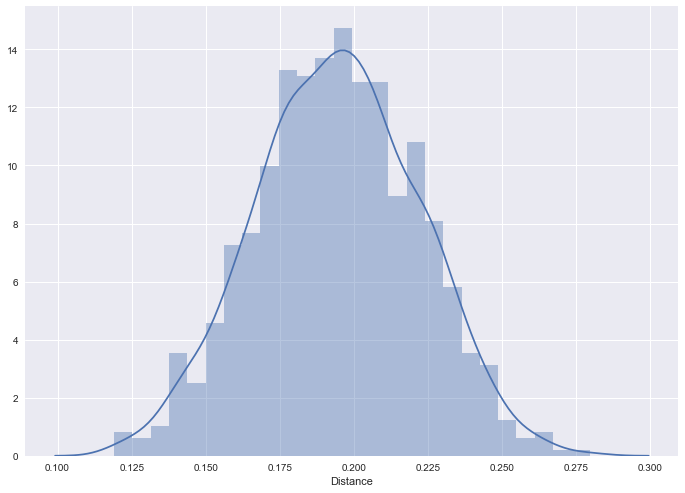

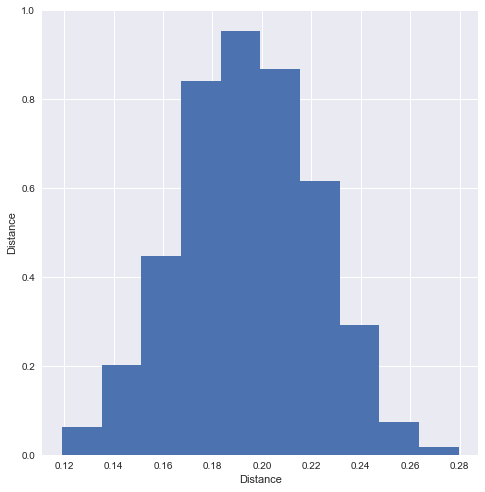

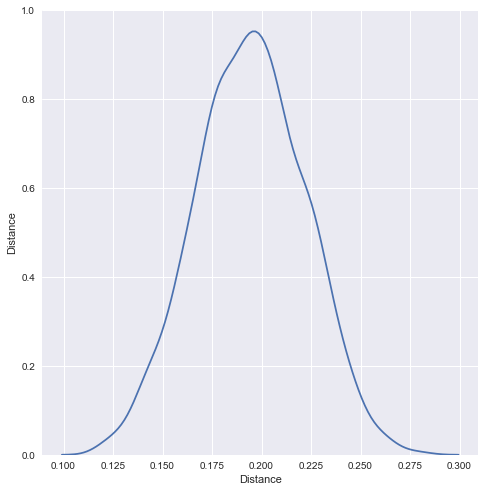

In [355]:
import seaborn as sns; sns.set(color_codes=True)
g = sns.distplot(distances.Distance)
g = sns.pairplot(distances, size=7)
g = sns.pairplot(distances, size=7, diag_kind='kde')

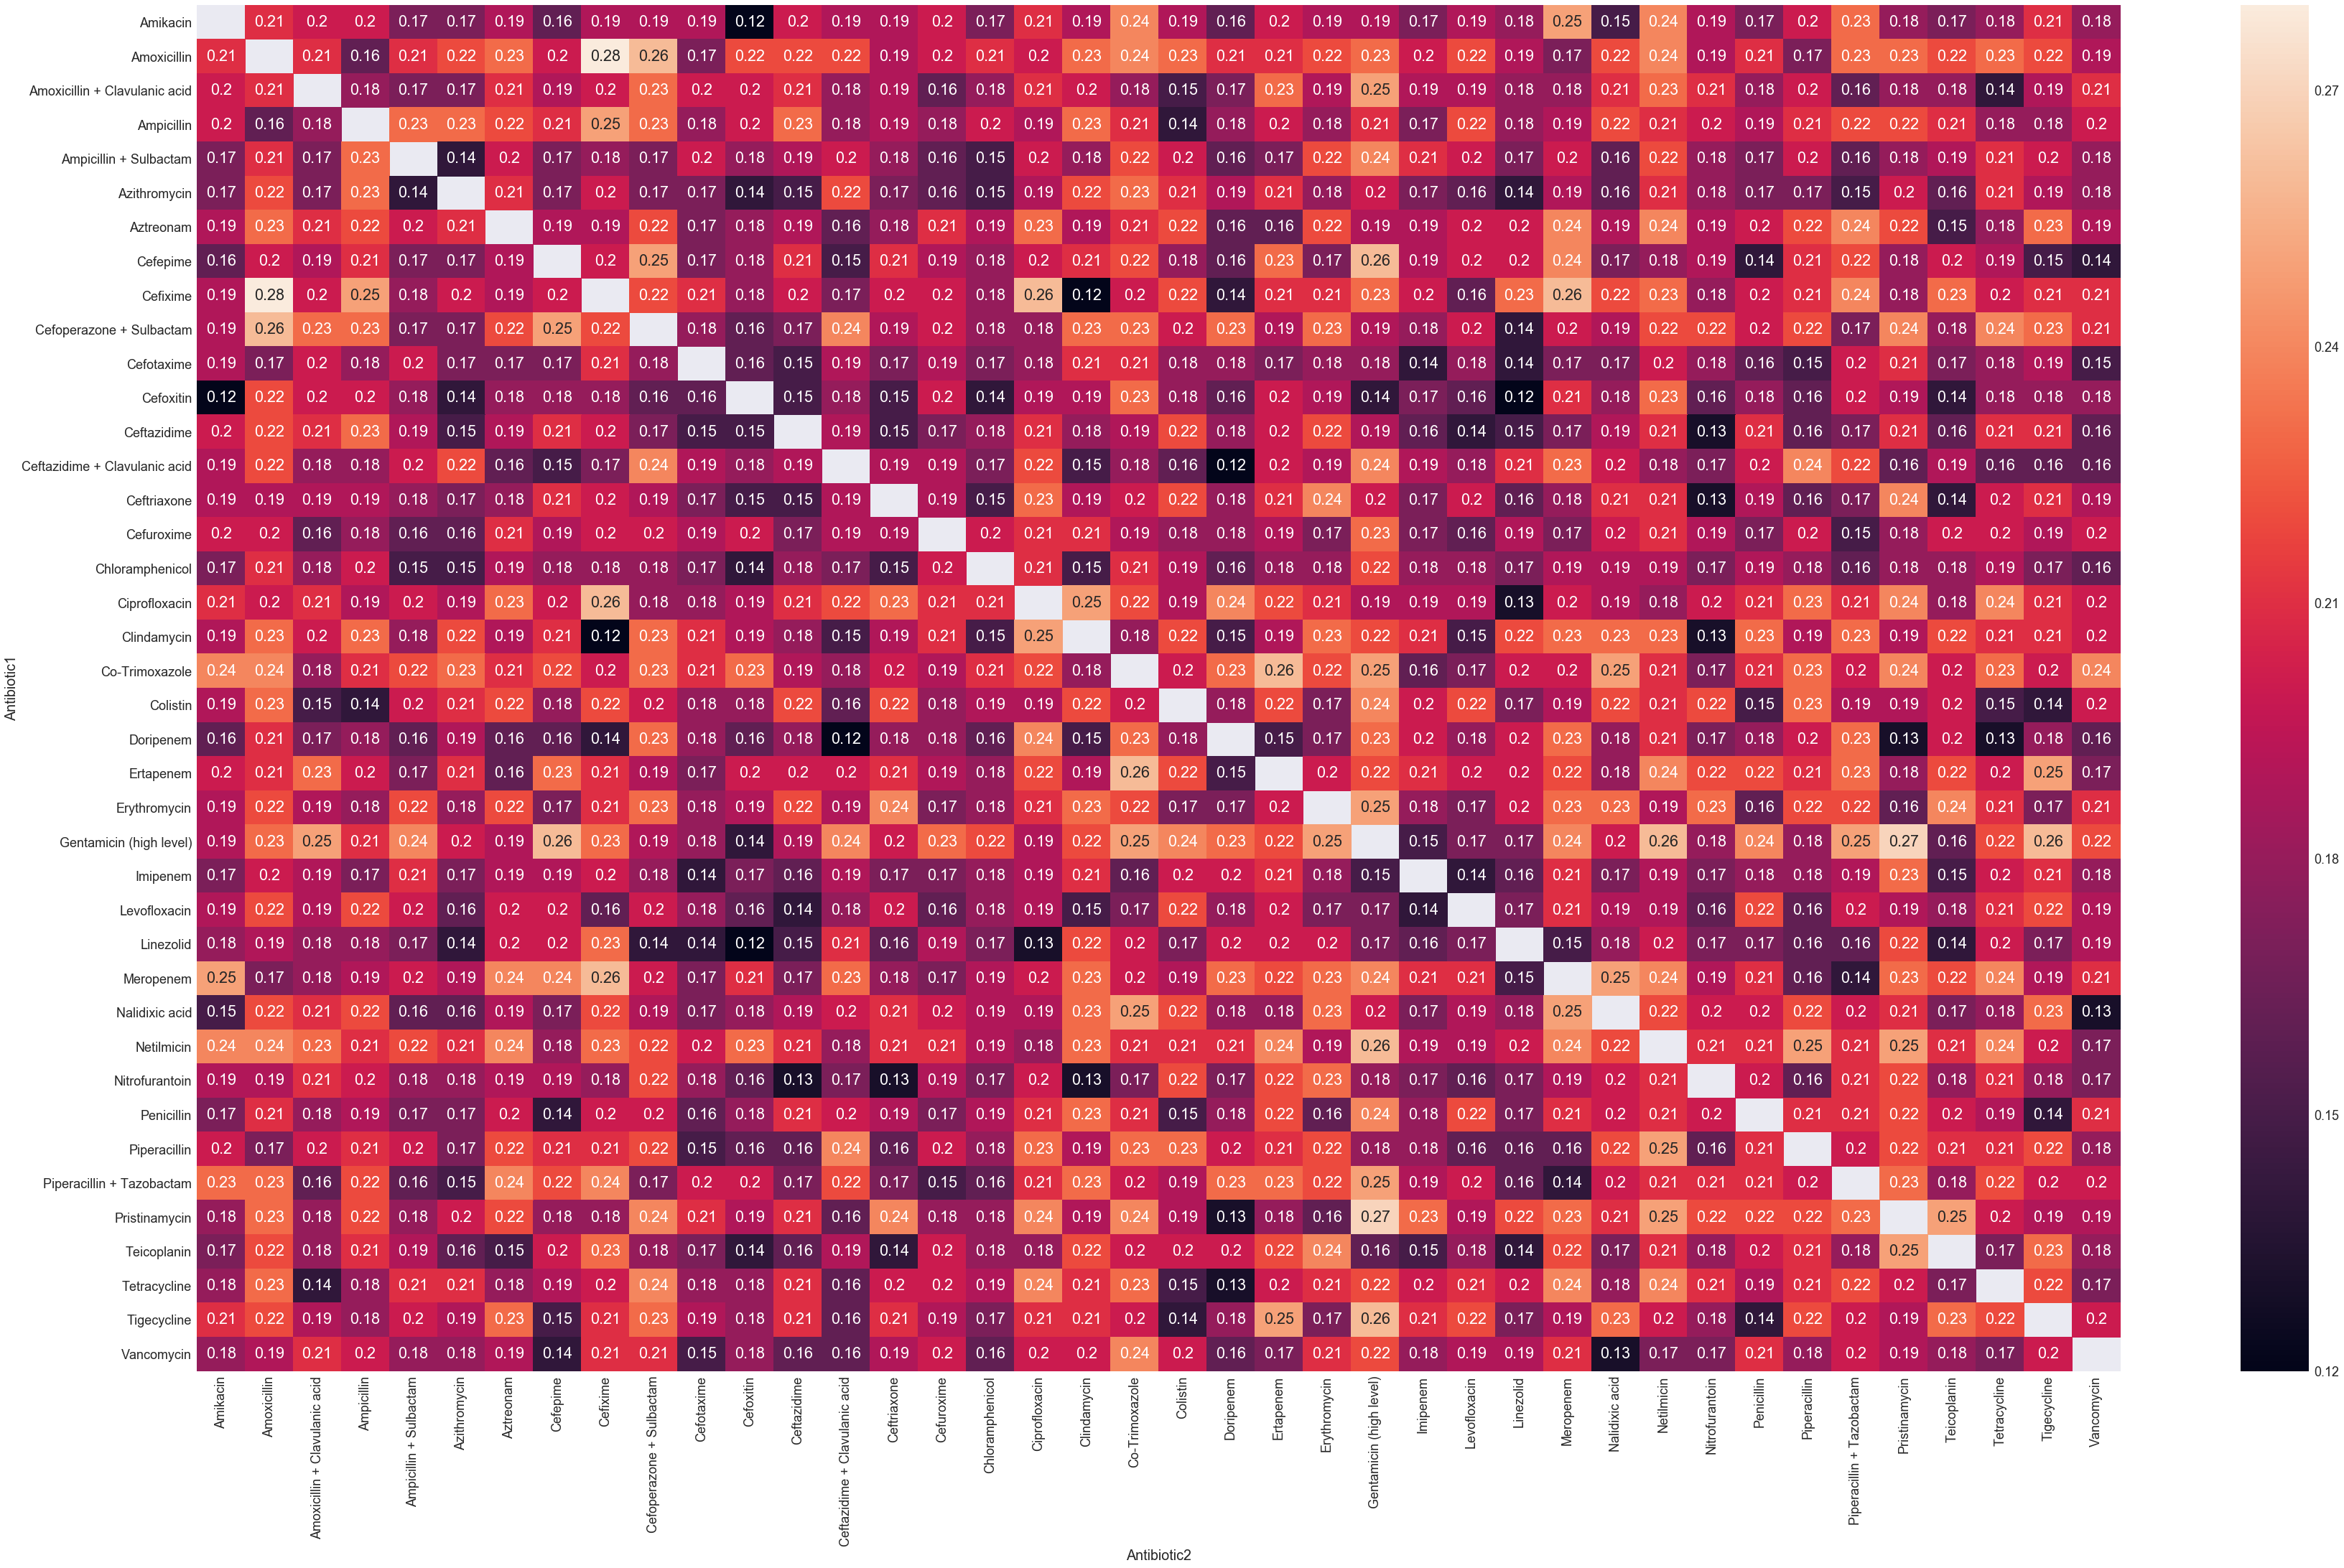

In [356]:
distances.Distance = distances.Distance.apply(lambda x: np.round(x, decimals=2))
plt.figure(figsize=(60, 35))
sns.set(font_scale=1.8) 
pivot = distances.pivot(index='Antibiotic1', columns='Antibiotic2', values='Distance')
ax = sns.heatmap(pivot,annot=True)
plt.show()